In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import quandl as ql
import statsmodels.formula.api as smf
pd.set_option("display.float_format", lambda x: "%.9f" % x)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import os
ql.ApiConfig.api_key = os.getenv("~~~~~~~~~~~~~~~~")

 # Return Forecasting:  Read Historical Daily Yen Futures Data from Quandl
 In this activity, you will pull historical Dollar-Yen exchange rate futures data from Quandl and test whether there is any predictable behavior using time-series models.

 * First, you'll need to download the futures data using the Quandl API, and return it as a Pandas DataFrame.
 * You'll need a Quandl API key (free): https://www.quandl.com/
 * (Use code "CHRIS/CME_JY1")
 * Trim the resulting data to include only from the the year 1990 through today.

In [54]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
fut = ql.get("CHRIS/CME_JY1")
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.000000000,3401.000000000,3398.000000000,3401.000000000,nan,3401.000000000,2.000000000,1.000000000
1976-08-03,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-04,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-05,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-06,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000


In [55]:
# Trim the dataset to begin on January 1st, 1990
#fut = ql.get("CHRIS/CME_JY1", start_date = "1990-01-01")
fut = fut.loc["1990-01-01":] 
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

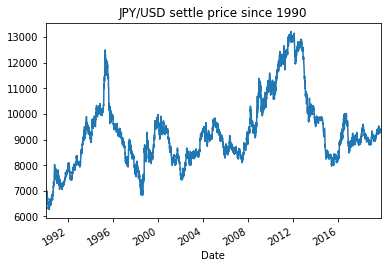

In [56]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE 
fut["Settle"].plot(title = "JPY/USD settle price since 1990")

 # Return Forecasting: MA/EWMA Smoothing of Futures Prices

 1. Plot the Settle Price, along with a moving average of 15 and 60 days. Use indexing to just plot the data from 2015 onward.
 2. What do you see now, in terms of short versus long-term trends?
 3. Try an exponential moving average, with a half life of 15 days.
 4. Which seems to respond faster, an exponential moving average with a half life of 15 days, or a moving average of 15 days?

 (15 days = 3 weeks)
 (60 days = 3 months)

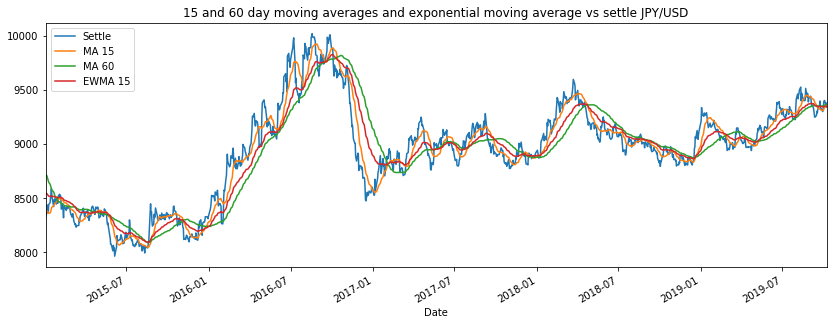

In [57]:
###### Moving averages and exponentially weighted moving averages 
# Create a dataframe using just the "Settle" price
df = fut[["Settle"]].copy()

# Add in columns for moving average windows of 15 and 60 days, and a column for an EWMA window of 15 days
# YOUR CODE HERE 
df["MA 15"] = df["Settle"].rolling(window=15).mean()
# YOUR CODE HERE 
df["MA 60"] = df["Settle"].rolling(window=60).mean()
# YOUR CODE HERE 
df["EWMA 15"] = df.Settle.ewm(halflife = 15).mean()
# Plot the settle price and moving average/ewma columns all in one plot from 2015:
df["2015":].plot(figsize=(14,5), title = "15 and 60 day moving averages and exponential moving average vs settle JPY/USD")

# Return Forecasting: Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

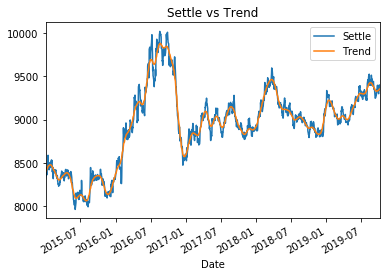

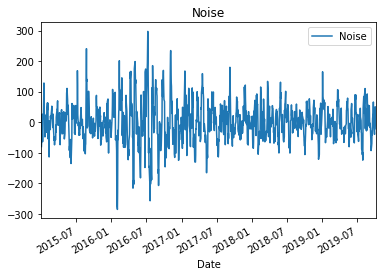

In [58]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(df["Settle"])

# Create a dataframe of just the settle price, and add in the "noise" and "trend" series from above:
futures_decomp = df[["Settle"]].copy()
futures_decomp["Noise"] = ts_noise 
futures_decomp["Trend"] = ts_trend 
futures_decomp

# Plot the "Settle" and "Trend" price 
# YOUR CODE HERE 
futures_decomp[["Settle", "Trend"]]["2015":].plot(title = "Settle vs Trend")

# Then plot the "noise" separately
# YOUR CODE HERE 
futures_decomp[["Noise"]]["2015":].plot(title = "Noise")

 # Return Forecasting: Seasonal Effects with Sklearn Linear Regression
 Using the full dataset, use a SKLearn linear regression to predict Yen futures ("settle") returns with *lagged* Yen futures returns and categorical calendar seasonal effects (e.g., day-of-week or week-of-year seasonal effects).


In [59]:
#Use the dataframe containing "Settle" Prices:
fut.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


In [71]:
from sklearn.linear_model import LinearRegression

# Construct a "Futures Return" column, using pandas pct_change() on the "Settle" price 
# If will be easier to also multiply this by 100, both to read and when we use it with SKLearn:
fut["Futures Return"] = fut["Settle"].copy().pct_change()*100

# Feature Engineering
# Create a second "Lagged Return" variable, that is the futures return variable shifted above, but lagged 1 day:
# We"ll use this lagged return as the feature vector X:
fut["Lagged Return"] = fut["Futures Return"].shift()
fut = fut.replace(-np.inf, np.nan).dropna()

# Construct a new "X" dataframe using just the "Lagged Return" variable:
X = fut["Lagged Return"].to_frame()

In [72]:
# Add into the X dataframe either a "dayofweek" or "weekofyear" column, (e.g., using X.index.weekofyear) 
X["Week of Year"] = X.index.weekofyear

# Create a new categorical X dataframe, by using pd.get_dummies() on the seasonal column created just above:
X_binary_encoded = pd.get_dummies(X, columns=['Week of Year'], drop_first = True)
X_binary_encoded.head()

,Lagged Return,Week of Year_2,Week of Year_3,Week of Year_4,Week of Year_5,Week of Year_6,Week of Year_7,Week of Year_8,Week of Year_9,Week of Year_10,...,Week of Year_44,Week of Year_45,Week of Year_46,Week of Year_47,Week of Year_48,Week of Year_49,Week of Year_50,Week of Year_51,Week of Year_52,Week of Year_53
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-20,-0.020460358,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-21,0.020464545,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-24,-0.204603581,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-25,0.020502307,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-26,0.327969663,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Create a "y" series, using just the "Futures Return" column created above.
y = fut["Futures Return"].copy()

# Construct a "LinearRegression" object:
model = LinearRegression()

# Fit a model using the X and y objects:
results = model.fit(X_binary_encoded, y)

In [74]:
# Construct predictions based on the X object:
predictions = model.predict(X_binary_encoded)
predictions

array([-0.06018054, -0.062047  , -0.06631766, ...,  0.07603817,
        0.0959319 ,  0.06921313])

 Summarize the quality of your model using R2 and root-mean-squared-error (RMSE) statistics. How good is it?

In [75]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate r2_score (r-squared)
r2 = r2_score(y, predictions)

# Calculate mean squared error 
# (A "good" MSE score will be close to zero while a "good" R2 Score will be close to 1.)
mse = mean_squared_error(y, predictions)

# Using mean squared eror above, calculate root-mean-squared error (RMSE)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Standard Deviation of Futures Return: {y.std()}")

Mean Squared Error (MSE): 0.2836217632125004
R-squared (R2 ): 0.04897160333507633
Root Mean Squared Error (RMSE): 0.5325615112008193
Standard Deviation of Futures Return: 0.5462949716796398


 #### Plotting and Independent (X) Variable Interpretation

 Plot the model predictions of returns against actual returns, for just data from 2018 onward.

In [76]:
# Create a "y" dataframe, using just the "Futures Return" column created above. 
y_df = y.to_frame()

# Add the model predictions from above as an additional column to that dataframe:
y_df["prediction"] = predictions
y_df.head()

,Futures Return,prediction
Date,,
2014-02-20,0.020464545,-0.060180537
2014-02-21,-0.204603581,-0.062047003
2014-02-24,0.020502307,-0.066317665
2014-02-25,0.327969663,-0.076584092
2014-02-26,-0.296250894,-0.090606788


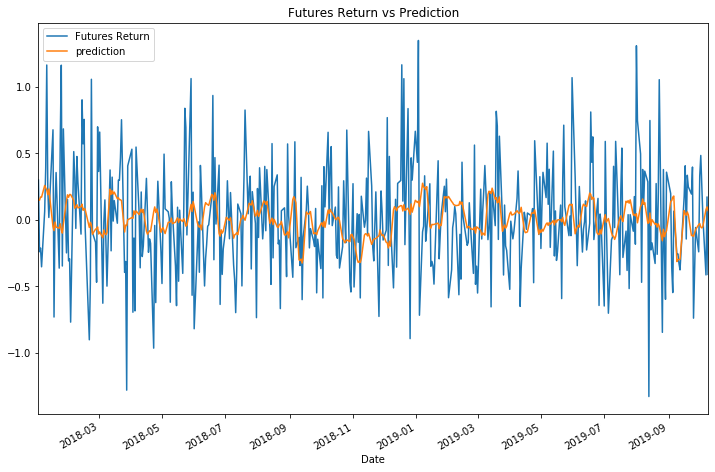

In [77]:
# Plot the two from 2018 onward
# YOUR CODE HERE 
y_df["2018":].plot(figsize=(12,8), title = "Futures Return vs Prediction")

 Separately, plot the calendar effects estimated from the model using matplotlib. Do you see any seasonal patterns?

In [78]:
# Construct a dataframe of the model calendar-effect coefficients and review the output:
results = pd.DataFrame(model.coef_, columns=["Coefficient"], index=X_binary_encoded.columns)

# Filter results so that it only includes either the day-of-week or week-of-year effect 
results = (results[results.index.str.contains("Week of Year")])

results.head(10)

,Coefficient
Week of Year_2,0.081602421
Week of Year_3,-0.210722750
Week of Year_4,-0.207140370
Week of Year_5,0.015870310
Week of Year_6,-0.049592050
Week of Year_7,-0.048015478
Week of Year_8,-0.220540719
Week of Year_9,-0.235076087
Week of Year_10,-0.265447676
Week of Year_11,0.047491463


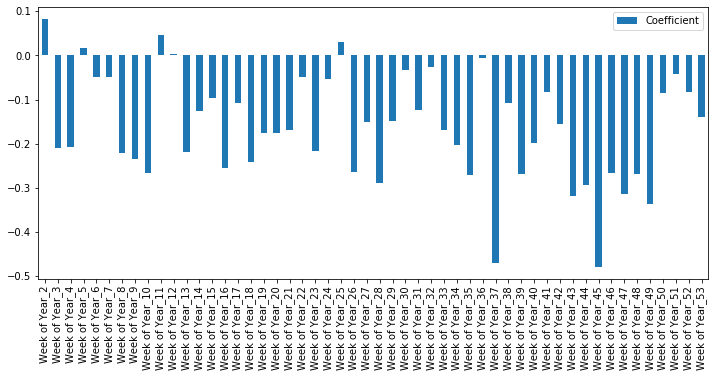

In [79]:
# Plot the results of the individual seasonal effects using pandas df.plot()
# YOUR CODE HERE 
results.plot(kind='bar',figsize=(12,5))


 # Return Forecasting: Autocorrelation and the ARMA Model

 Using futures Settle *Returns*, estimate an ARMA model.
 1. Set the AR and MA ("p" and "q") parameters to p=2 and q=1.
 2. Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30. If, when looking at the correlation graphs, additional lags seem important for predicting returns, increase the number of lags in the ARMA model from (1).
 3. Does increasing the number of "p" or "q" increase the ability of the model? Compare your results between the two models by comparing the Bayseian Information Criterion, or BIC.

In [80]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Create a series using "Settle" price percentage returns, and drop any nan's:
df = fut[["Settle"]].pct_change().dropna()

# Estimate and ARMA model using statsmodels
# Hint: ARMA(df, order=(p, q)).fit()
autoregressive_count = 2
moving_average_window = 1
model = ARMA(df.values, order=(autoregressive_count,moving_average_window)).fit()
model

In [81]:
# Output model summary results:
# YOUR CODE HERE 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1408
Model:                     ARMA(2, 1)   Log Likelihood                5339.002
Method:                       css-mle   S.D. of innovations              0.005
Date:                Thu, 10 Oct 2019   AIC                         -10668.004
Time:                        16:24:27   BIC                         -10641.754
Sample:                             0   HQIC                        -10658.194
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.773e-05      0.000     -0.116      0.908      -0.000       0.000
ar.L1.y        0.3011      0.339      0.889      0.374      -0.363       0.965
ar.L2.y        0.0464      0.027      1.743      0.082      -0.006       0.099
ma.L1.y       -0.3148      0.338     -0.930      0.352      -0.978       0.349
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4192           +0.0000j            2.4192            0.0000
AR.2           -8.9116           +0.0000j            8.9116            0.5000
MA.1            3.1766           +0.0000j            3.1766            0.0000
-----------------------------------------------------------------------------
"""

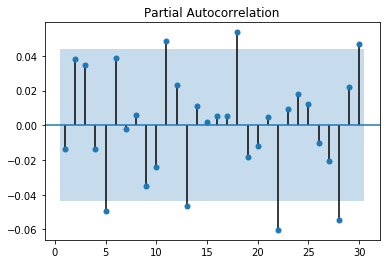

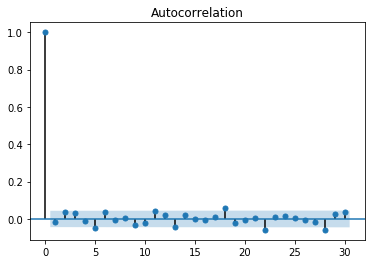

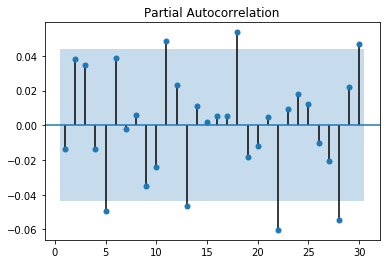

In [82]:
# Plot autocorrelation and partial correlation graphs with an alpha of 0.10 and lags=30.
import statsmodels
# Autocorrelation (For detecting # of MA ("P") Lags)
# YOUR CODE HERE 
sm.graphics.tsa.plot_acf(df.Settle, lags=30, alpha=0.10)

# Partial Autocorrelation (For detecting # of MA ("P") Lags)
# YOUR CODE HERE 
sm.graphics.tsa.plot_pacf(df.Settle, lags=30, zero=False, alpha=0.10)


In [111]:
autoregressive_count = 17
moving_average_window = 6

# Esimate your model based on your interpretation of the autocorrelation/partial autocorrelation plots:
model = ARMA(df.values, order=(3,1))
model
# Review model summary results:
review = model.fit()
review.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1409
Model:                     ARMA(3, 1)   Log Likelihood               -7489.111
Method:                       css-mle   S.D. of innovations             49.137
Date:                Thu, 10 Oct 2019   AIC                          14990.222
Time:                        16:38:11   BIC                          15021.725
Sample:                             0   HQIC                         15001.995
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9118.6128    229.930     39.658      0.000    8667.959    9569.267
ar.L1.y        1.2966      0.300      4.323      0.000       0.709       1.884
ar.L2.y       -0.2468      0.302     -0.816      0.415      -0.840       0.346
ar.L3.y       -0.0533      0.027     -1.997      0.046      -0.106      -0.001
ma.L1.y       -0.3120      0.300     -1.041      0.298      -0.899       0.275
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0055           +0.0000j            1.0055            0.0000
AR.2            2.3394           +0.0000j            2.3394            0.0000
AR.3           -7.9754           +0.0000j            7.9754            0.5000
MA.1            3.2050           +0.0000j            3.2050            0.0000
-----------------------------------------------------------------------------
"""

 # Return Forecasting: Deploying the ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags

 2. Plot the residuals from the model. If residuals are the part of returns that our model *doesn"t* explain, does it seem like our model has missed any seasonality?
 3. Construct a 15 day (3 week) forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [ ]:
# For ARIMA, construct a dataframe using just the futures "Settle" prices:
df = fut[["Settle"]]
df.head()

                             ARIMA Model Results                              
Dep. Variable:               D.Settle   No. Observations:                 1408
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7479.970
Method:                       css-mle   S.D. of innovations             49.084
Date:                Thu, 10 Oct 2019   AIC                          14975.940
Time:                        16:31:17   BIC                          15017.939
Sample:                             1   HQIC                         14991.636
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3110      1.334     -0.233      0.816      -2.925       2.303
ar.L1.D.Settle    -0.5832      0.313     -1.861      0.063      -1.197       0.031
ar.L2.D.Settle     0.0394      0.031

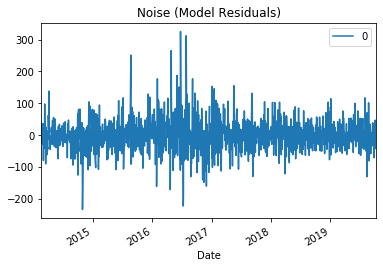

                   0
count 1408.000000000
mean     0.000453513
std     49.101403450
min   -234.074627319
25%    -27.676362845
50%     -0.825230211
75%     25.467073152
max    325.322186289


In [86]:
from statsmodels.tsa.arima_model import ARIMA
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(df['Settle'], order=(5, 1, 1))
model_fit = model.fit()
# Output model summary results:
print(model_fit.summary())
# plot residual errors:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Noise (Model Residuals)")
plt.show()
print(residuals.describe())

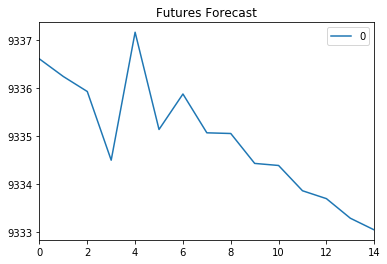

In [87]:
# Construct a 15 day (3 week) forecast for the Settle Price. 
# What does the model forecast will happen to the Japanese Yen in the near term?
# Specifically, construct a pandas DataFrame containing ARIMA model forecasts for a 15-day window:
# YOUR CODE HERE 
pd.DataFrame(model_fit.forecast(steps=15)[0]).plot(title="Futures Forecast")

 # Volatility Forecasting

 Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

### Volatility Forecasting: GARCH and EGARCH Models
Using the "arch" package, estimate either GARCH(1,1) or an EGARCH(p,q) volatility forecast model on futures settle returns.

In [88]:
from arch import arch_model

In [89]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by *100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns=(fut[["Settle"]].pct_change()*100)
returns=returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-03,0.256040967
2019-10-04,0.021282256
2019-10-07,-0.414915687
2019-10-08,0.170931040
2019-10-09,-0.410600971


In [90]:
# Estimate a GARCH(1,1) model using the "arch" package:
# (We need to drop all NaN"s first in order to get this to run):
am = am = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)
res = am.fit(disp="off")

In [91]:
# Output the summary results of the GARCH model:
print(res.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1067.08
Distribution:                  Normal   AIC:                           2140.17
Method:            Maximum Likelihood   BIC:                           2155.92
                                        No. Observations:                 1408
Date:                Thu, Oct 10 2019   Df Residuals:                     1405
Time:                        16:31:18   Df Model:                            3
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.3884e-03  1.647e-03      1.450      0.147 

### Volatility Forecasting: Identifying Patterns of Clustered Volatility

GARCH/EGARCH, etc. models are good for capturing the "volatility clustering" effect that is common in financial data. After estimating your model, can you identify periods when volatility clusters together?

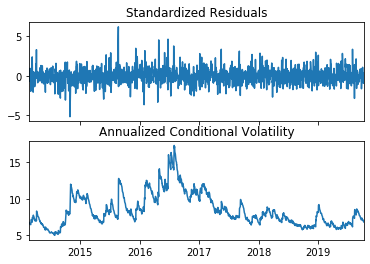

In [92]:
# Plot the model"s conditional volatility for the Yen:
# Hint: use .plot(annualize="D")
fig = res.plot(annualize='D')

### Volatility Forecasting: 3-day Yen Volatility Forecasts using GARCH/EGARCH
  * Let's do some forecasting of near-term risk. Specifically, use the .forecast() method to calculate 3-day forecasts. Then plot the resulting 3-day annualized variance. Is Yen volatility expected to rise or fall in the near term?

In [93]:
# Note--You can either specify today"s date manually, or use pd.datetime.today().strftime("%Y-%m-%d") 
# (example format: start="2019-06-28")
# If you have problems with datetime, 
# specify data date manually using the most recent trading date in the dataframe
todays_date = pd.datetime.today().strftime("%Y-%m-%d")                  
# todays_date = '2019-07-05'
# Forecast volatility, from today"s date until the following three days:
forecast_horizon = 3
forecasts = res.forecast(start='2019-10-04', horizon=forecast_horizon)
forecasts

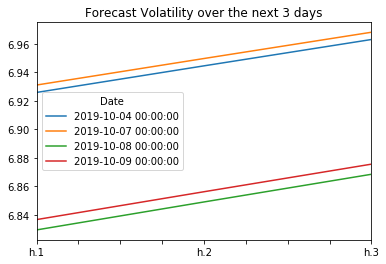

In [94]:
# Plot the annualized volatility forecast using pd.plot():
# (Make sure to use dropna() on the forecasts before plotting):
# (There are 252 trading days in a year)
# Note: each column in forecasts.variance represents one day ahead: 
plot_title = f"Forecast Volatility over the next {forecast_horizon} days"
model_forecasts = np.sqrt(forecasts.variance.dropna() * 252)
model_forecasts.dropna().T.plot(title=plot_title)

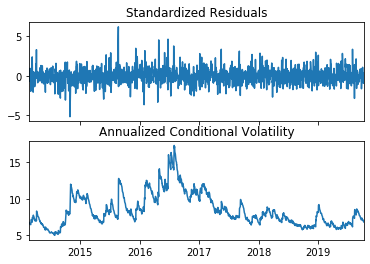

In [95]:
fig = res.plot(annualize='D')

 # Out-of-Sample Predictions
 So far, you"ve used the full dataset to construct a model. Let's try a more rigorous technique.

### Out-of-Sample Predictions: Slicing the Data into Training and Test Set ("One Shot" Approach)

Using the SKLearn regression model and just lagged returns as the independent variable, start by estimating a model using **training data** from January, 2015 through December 2017.

In [96]:
# If you haven"t already, create and add "Futures Return" and "Lagged Futures Return" variables to your dataframe:
# Replace inf, -inf with np.nan, then drop any row with at least one np.nan in the dataframe
fut["Futures Return"] = fut.Settle.pct_change() * 100
fut["Lagged Return"] = fut.Settle.shift()
fut = fut.replace(-np.inf, np.nan).dropna()
fut[["Futures Return", "Lagged Return"]].head()

,Futures Return,Lagged Return
Date,,
2014-02-21,-0.204603581,9775.000000000
2014-02-24,0.020502307,9755.000000000
2014-02-25,0.327969663,9757.000000000
2014-02-26,-0.296250894,9789.000000000
2014-02-27,0.389344262,9760.000000000


In [97]:
# Using datetime index slicing, create a "training" data dataframe using data from just 2015-01-01 to 2017-12-31
train = fut["2015-01-01":"2017-12-31"]
print("Training set covers from ", train.index.min(), " to ", train.index.max())
train.head(2)

Training set covers from  2015-01-02 00:00:00  to  2017-12-29 00:00:00


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Futures Return,Lagged Return
Date,,,,,,,,,,
2015-01-02,8352.000000000,8353.000000000,8286.000000000,8310.000000000,34.000000000,8315.000000000,101438.000000000,222022.000000000,-0.407234399,8349.000000000
2015-01-05,8305.000000000,8382.000000000,8293.000000000,8371.000000000,56.000000000,8371.000000000,165487.000000000,226085.000000000,0.673481660,8315.000000000


In [98]:
# Using datetime index slicing, create a "test" data dataframe using data from 2018-01-01 through the end of the data
test = fut["2018-01-01":]
print("Test set covers from ", test.index.min(), " to ", test.index.max())
test.head(2)

Test set covers from  2018-01-02 00:00:00  to  2019-10-09 00:00:00


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Futures Return,Lagged Return
Date,,,,,,,,,,
2018-01-02,8909.500000000,8957.500000000,8898.500000000,8938.000000000,26.500000000,8940.500000000,96714.000000000,227884.000000000,0.297285169,8914.000000000
2018-01-03,8943.000000000,8947.500000000,8913.000000000,8921.000000000,21.500000000,8919.000000000,93498.000000000,226582.000000000,-0.240478720,8940.500000000


  * Then use the model developed on a test set using data from 2018 onward.

In [99]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged Return"].to_frame()
y_train = train["Futures Return"] 
X_test = test["Lagged Return"].to_frame()
y_test = test["Futures Return"]

In [100]:
# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
# YOUR CODE HERE 
model = LinearRegression()
model.fit(X_train, y_train)
# Score how that model works using only the test data
# YOUR CODE HERE 
predictions = model.predict(X_test)
# And make a prediction of "y" values for just the test dataset
predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [101]:
Results.head()

,Futures Return,Predicted Return
Date,,
2018-01-02,0.297285169,0.003379725
2018-01-03,-0.240478720,0.001429719
2018-01-04,-0.213028366,0.003011799
2018-01-05,-0.353932584,0.004409917
2018-01-08,0.062017252,0.006727848



  * Compare the RMSE from the model using the test sample to the RMSE when using the full-sample. Are the results surprising?

In [102]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(Results["Futures Return"], Results["Predicted Return"])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
one_shot_rmse = np.sqrt(mse) 
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {one_shot_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4146681461284975


In [103]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train) 

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(in_sample_results["Futures Return"],in_sample_results["In-sample Predictions"])
 

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse) 
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.624936836505917


### Out-of-Sample Predictions: The Rolling Out-of-Sample Approach

Let's take the model above (i.e., SKLearn predicting futures returns with lagged futures returns), but apply it using a rolling, out of sample approach. This method, which is specific to time-series predictions, will be a more realistic and more rigorous approximation of how the model would perform in real life.

Specifically, start at the beginning of the dataset and "roll forward" one week at a time, using a 26-week (6 month) rolling training window.

In [104]:
# Main Idea: Each week, re-estimate the model, then trade on it the following week. 
# Continue this "out of sample" approach throughout the dataset.

In [105]:
# Construct an empty placeholder dataframe, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
# Construct an empty placeholder dataframe, with a column named "Actual Returns"
# (Each iteration of the loop, we"ll append that week"s predictions to this DataFrame)
all_actuals = pd.DataFrame(columns=["Actual Returns"])

# construct a list of all pandas weekly periods that are in the dataset:
weeks = fut.index.to_period("w").unique()

# Specify a training window (26 weeks (6 months) of data)
training_window = 26  

# Write a for loop that iterates from 0 to the number of weeks (minus the training window) in the dataset:
# We have to subtract the length of the training window because
# Going beyond this goes beyond the length of our dataset    
for i in range(0, (len(weeks) - training_window - 1)):
# Create an datetime object to mark the beginning of the training window (which changes, for each "i"):     
    #beginning_training_week = # YOUR CODE HERE 
# Create a string variable from that time object with format="%Y-%m-%d"
    start_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
# Create an datetime object to mark the ending of the training window (which would be "i"+training_window_length):  
    #ending_training_week = # YOUR CODE HERE
# Create a string variable from that time object with format="%Y-%m-%d"
    end_training_period = weeks[training_window + i].end_time.strftime(format="%Y-%m-%d")
# Create a datetime object that marks the week of test-window data:
    test_week = weeks[training_window+i+1]
# Create a string variable from the beginning of that time object with format="%Y-%m-%d"
    start_test_week = test_week.start_time.strftime(format="%Y-%m-%d")
# Create a string variable from the end of that time object with format="%Y-%m-%d"    
    end_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
# Create a dataframe that includes only data during the training window
# (Use datetime slicing and the two start and end string dates constructed above):
    train =  fut[start_training_period:end_training_period]
# Do the same to construct a dataframe including data in the test sample window:    
    test =  fut[start_test_week:end_test_week] 
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
    X_train = train["Lagged Return"].to_frame()
    y_train = train["Futures Return"]
    X_test = test["Lagged Return"].to_frame()
    y_test = test["Futures Return"]
# Fit a linear regression to the two training dataframes
    model = LinearRegression()
    model.fit(X_train, y_train)
# Use the model to construct predictions on the X test dataframe,
# and save them as a temporary pandas DataFrame 
    predictions =  model.predict(X_test)
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
# Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
# Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    # Once the loop is done, concatenate (combine) the two dataframes to a final "Results" dataframe:    
    Results =  pd.concat([all_actuals, all_predictions], axis=1)

    
Results.head()



,Actual Returns,Out-of-Sample Predictions
2014-08-25,-0.051958849,0.222425316
2014-08-26,-0.103971720,0.229317155
2014-08-27,0.208159867,0.243100833
2014-08-28,0.197341088,0.215533478
2014-08-29,-0.425002591,0.189344490


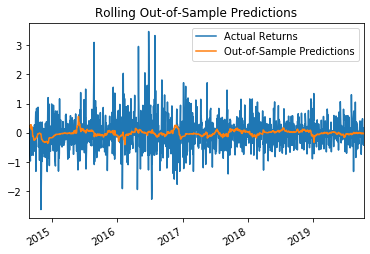

In [106]:
# Plot the results:
Results.plot(title="Rolling Out-of-Sample Predictions")

  * Evaluate the model RMSE.
      * Which has the better RMSE--this more robust method, or the single ("one-shot") training and test split just above?

In [107]:
# Calculate the mean_squared_error on the Results DataFrame:
# (This compares the average (squared) difference between actual and model-predicted returns)
rolling_mse = mean_squared_error(Results["Actual Returns"],Results["Out-of-Sample Predictions"]) 
# Then use that to calculate the Root-Mean-Squared Error (RMSE):
rolling_rmse = np.sqrt(rolling_mse) 
rolling_rmse

0.5738940851882437

In [108]:
# Compare the RMSE from the training-testing single split versus the rolling out-of-sample approach we just did:
# YOUR CODE HERE 
print(one_shot_rmse)

0.4146681461284975


Challenge: Can you calculate the out-of-sample R2? Based on this, should we bet money on this model?

In [109]:
# YOUR CODE HERE 